In [1]:
import pandas as pd
import numpy as np
import json
import os
import string
import re
import random

import nltk
from nltk import word_tokenize
from nltk.corpus import (wordnet, stopwords)
from nltk.stem.snowball import SnowballStemmer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

from sklearn.linear_model import (LogisticRegression, LogisticRegressionCV)
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (confusion_matrix, 
                             recall_score, 
                             f1_score, 
                             accuracy_score, 
                             precision_score,
                             roc_curve, auc, roc_auc_score)

import warnings
warnings.filterwarnings('ignore')

from datetime import *
from bisect import bisect

In [2]:
def parse_datetime(raw_datetime, dtformat):
    if len(raw_datetime)<5:
        return np.nan, 365, np.nan, np.nan    
    datetime_obj = datetime.strptime(raw_datetime,dtformat) 
    return datetime_obj.hour

def bizhour(hh):
    biz = ['Late','Early','Business','Evening', 'Late']
    breakpoints = [5, 10, 17,20]
    return biz[bisect(breakpoints, hh)]

def get_descr_bizhour(hhmat):
    return np.array(list(map(bizhour, hhmat)))

In [3]:
jsons_data = pd.DataFrame(columns = ['user_record_id', 'text', 'likes', 'replies', 'retweets'])
tweets_concat = pd.DataFrame(columns = ['user_id', 'n_tweets', 'text', 'likes', 'replies', 'retweets'])

directory = '/Users/jenniferpolson/Documents/School/2018-W/BE 223B/Project 1/tweet_files-1/'
for filename in os.listdir(directory):
    if filename.endswith('.json'):
        df = pd.DataFrame(json.load(open(directory + str(filename))))
        df['tweet_id'] = df['user_record_id'].map(str) + '_' + df.index.astype(str)
        jsons_data = jsons_data.append(df) 
        wk_list = df.weekday.tolist()
        n_tweets = len(df.index)
        
        hours = np.zeros(len(df.index))

        for i,rd in enumerate(df['time']):
            hours[i]=parse_datetime(rd,'%H:%M:%S')

        timeofday = list(get_descr_bizhour(hours))
        
        tweets_concat = tweets_concat.append({'n_tweets': n_tweets,
                                              'text':df['text'].str.cat(sep=', '), 
                                              'likes':df.likes.astype(int).sum(), 
                                              'replies':df.replies.astype(int).sum(), 
                                              'retweets':df.retweets.astype(int).sum(), 
                                              #'weekday_mean': df.weekday.astype(int).mean(),
                                              #'wkday_0': wk_list.count(0),
                                              #'wkday_1': wk_list.count(1),
                                              #'wkday_2': wk_list.count(2),
                                              #'wkday_3': wk_list.count(3),
                                              #'wkday_4': wk_list.count(4),
                                              #'wkday_5': wk_list.count(5),
                                              #'wkday_6': wk_list.count(6),
                                              #'time_late': timeofday.count('Late'),
                                              #'time_early': timeofday.count('Early'),
                                              #'time_business': timeofday.count('Business'),
                                              #'time_evening': timeofday.count('Evening'),
                                              'user_id':df.user_record_id.iloc[0]
                                             }, ignore_index = True)

In [4]:
jsons_data = pd.DataFrame(columns = ['user_record_id', 'text', 'likes', 'replies', 'retweets'])
tweets_concat = pd.DataFrame(columns = ['user_id', 'n_tweets', 'text', 'likes', 'replies', 'retweets'])

directory = '/Users/jenniferpolson/Documents/School/2018-W/BE 223B/Project 1/tweet_files/'
for filename in os.listdir(directory):
    if filename.endswith('.json'):
        df = pd.DataFrame(json.load(open(directory + str(filename))))
        df['tweet_id'] = df['user_record_id'].map(str) + '_' + df.index.astype(str)
        jsons_data = jsons_data.append(df) 
        tweets_concat = tweets_concat.append({'user_id':df.user_record_id.iloc[0], 
                                              'n_tweets': len(df.index),
                                              'text':df['text'].str.cat(sep=', '), 
                                              'likes':df.likes.astype(int).sum(), 
                                              'replies':df.replies.astype(int).sum(), 
                                              'retweets':df.retweets.astype(int).sum()}, ignore_index = True)

In [5]:
#jsons_data.to_csv('jsons_data.csv')
#tweets_concat.to_csv('tweets_concat.csv')

In [6]:
tweets_concat

,user_id,n_tweets,text,likes,replies,retweets
0,2532,21,"hey gorgeous , @Juicegyal happy birthday your ...",3,2,2
1,2597,57,Your creative prowess is readily apparent at w...,1,4,2
2,2607,345,"Pig is crazy omg , thanks, Who rap I get the d...",44,69,10
3,2625,47,"Ran off with the plug twice, Try Jesus. Don't ...",1,3,4
4,2648,9,"I need to stop before, I really don't know wh...",0,0,0
5,2670,572,"Bouta go get food n watch a movie, I should go...",51,31,29
6,2671,12,Things were better when the seafood place was ...,10,2,1
7,2683,94,Maintaining a cool and calm attitude can be a ...,2,5,4
8,2697,6,Rüyamda saçımı tam yeşil yapıcam... Uyandım......,13,0,0
9,2699,204,hey! No the belt is lanvin i had the same prob...,1860,233,282


In [7]:
#Karthik's code
class RepeatReplacer(object):
    """ Removes repeating characters until a valid word is found.
    >>> replacer = RepeatReplacer()
    >>> replacer.replace(‘looooove’)
    ‘love’
    >>> replacer.replace(‘oooooh’)
    ‘ooh’
    >>> replacer.replace(‘goose’)
    ‘goose’
    """

    def __init__(self):
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'

    def replace(self, word):
        if wordnet.synsets(word):
            return word

        repl_word = self.repeat_regexp.sub(self.repl, word)

        if repl_word != word:
            return self.replace(repl_word)
        else:
            return repl_word
    
    
def process_tweets (tweets, textcol):
    processed_text = []
    for text in tweets[textcol]:
        #replace hyperlinks - leaves xa0 off for some reason
        test = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' hyperlink ', text).replace('\xa0', '')
        #replace mentions
        test = re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)', ' mention ', test)
        #replace picture links
        test = re.sub(r'pic.twitter\S+', ' image ', test)
        test = "".join((char for char in test if char not in string.punctuation + '—–-…’0123456789')).lower()\

        #remove repeat letters
        tokens = [RepeatReplacer().replace(w) for w in word_tokenize(test)]
        #employ stemmer
        stemmer = SnowballStemmer("english")
        tokens = [stemmer.stem(w) for w in tokens]
        #get rid of stop words
        filtered_string = ' '.join([w for w in tokens
                             if not w in set(stopwords.words('english'))])

        processed_text.append(filtered_string)

    tweets[textcol] = processed_text
    
    return tweets

def tfidf_vector (tweets, textcol):
    tf = TfidfVectorizer(analyzer='word', min_df = 15, stop_words = 'english')

    tfidf_matrix =  tf.fit_transform(tweets[textcol])
    feature_names = tf.get_feature_names() 
    dense = tfidf_matrix.todense()
    df = pd.DataFrame(dense)
    df.columns = feature_names
    
    return df

def sentiment_analysis(text):
    analyzer = SentimentIntensityAnalyzer()
    neg = []
    neu = []
    pos = []
    for sentence in text:
        vs = analyzer.polarity_scores(sentence)
        neg.append(vs['neg'])
        neu.append(vs['neu'])
        pos.append(vs['pos'])
    return neg, pos, neu

def safe_div(x,y):
    if y == 0:
        return 0
    return x / y

In [8]:
#split into folds
def create_folds(full_data, n): 
    nlist = list(range(0,len(full_data)-1))
#    random.seed(16)
    random.shuffle(nlist)
    fold_size = len(nlist) / n
    ints = [nlist[int(round(fold_size * i)): 
                  int(round(fold_size * (i + 1)))] 
             for i in range(n)]
    fold = [full_data.iloc[ints[i],:] for i in range(n)]
    return fold

def binary_metrics (test, label, pred):
    acc = accuracy_score(test[label], test[pred])
    f1 = f1_score(test[label], test[pred])
    prec = precision_score(test[label], test[pred])
    rec = recall_score(test[label], test[pred])
    roc_auc = roc_auc_score(test[label], test[pred])
    
    tn, fp, fn, tp = confusion_matrix(test[label], test[pred]).ravel()
    
    return roc_auc, acc, prec, rec, f1

def rfc_metrics (test, label, pred):
    tn, fp, fn, tp = confusion_matrix(test[label], test[pred]).ravel()
    
    roc_auc, acc, prec, rec, f1 = binary_metrics(test, label, pred)
    
    roc = roc_curve(test[label], test[pred])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = test[label].nunique()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test[label], test[pred])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test[label].ravel(), test[pred].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8,5))
    lw = 2
    plt.plot(fpr[1], tpr[1], color='gold',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    plt.show()
    
    show_confusion_matrix(test, label, pred)
    
    return details

def show_confusion_matrix(test, label, pred):
    
    C = confusion_matrix(test[label], test[pred])
    tn, fp, fn, tp = C.ravel()
    
    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)


    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['Show', 'No Show'])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(['Show', 'No Show'])
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,'True Negatives: %d\n(Total Negatives: %d)'%(tn,NN),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(0,1,'False Negatives: %d'%fn,
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,0,'False Positives: %d'%fp,
           va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,1,'True Positives: %d\n(Total Positives: %d)'%(tp,NP),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,'True Negative Rate' + '\n' +'(Specificity):%.2f'%(tn / (fp+tn+0.)),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(2,1,'True Positive Rate' + '\n' + '(Sensitivity):%.2f'%(tp / (tp+fn+0.)),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(2,2,'F-1 Score: %.2f'%(round(2*tp/((2*tp) + fp + fn),3)),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(0,2,'Negative Predictive ' + '\n' + 'Value: %.2f'%(1-fn/(fn+tn+0.)),
           va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    ax.text(1,2,'Positive Predictive ' + '\n' + 'Value: %.2f'%(tp/(tp+fp+0.)),
            va='center', ha='center', bbox=dict(fc='w',boxstyle='round,pad=1'))
    plt.tight_layout()
    plt.show()
    
    return None

def run_model(full, test, label, pred, plot = False, CV = False):
    train = pd.concat([full, test]).drop_duplicates(keep=False)
    trainArr = train.drop(['variable', 'binary_label'], axis = 1).as_matrix()
    trainRes = train.as_matrix(['binary_label'])
    testArr = test.drop(['variable', 'binary_label'], axis = 1).as_matrix()
    
    if CV:
        lr_cv = LogisticRegressionCV(scoring = 'roc_auc')
        lr_cv.fit(trainArr, trainRes)
        lr_cv.fit(trainArr, trainRes)
        predictions = lr_cv.predict(testArr)
    else:
    #gridsearchfsdfdsfds
        param_test1 = {'C':[0.0001,0.001,0.01,0.1,1,10,100,1000],
                       'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                      }
        gridsearch = GridSearchCV(estimator = LogisticRegression(class_weight = 'balanced'),
                                  param_grid = param_test1, scoring = 'roc_auc')

        gridsearch.fit(trainArr,trainRes)

        clf_lr = LogisticRegression(C=list(gridsearch.best_params_.values())[0],
                                    solver=list(gridsearch.best_params_.values())[1])

        clf_lr.fit(trainArr, trainRes)
        predictions = clf_lr.predict(testArr)
        
    data = pd.DataFrame(list(test[label]),columns=[label], index = test.index)
    data[pred] = pd.Series(list(predictions), index=data.index)                
    
    if plot:
        roc_auc, acc, prec, rec, f1 = rfc_metrics(data, label, pred)
    else:
        roc_auc, acc, prec, rec, f1 = binary_metrics(data, label, pred)
    
    return data, [roc_auc, acc, prec, rec, f1]

In [9]:
def create_model_df (tweets, labels, 
                     textcol = 'text', idcol = 'user_id', 
                     repcol = 'replies', lcol = 'likes', retcol = 'retweets', 
                     bincol = 'variable'):
    df = process_tweets(tweets, textcol)
    #generate tfidf, concatenate with processed tweets
    new_features = pd.concat([df, tfidf_vector(df, textcol)], axis = 1)
    new_features.index = new_features[idcol]
    #generate sentiment
    new_features['Negative Sentiment'], new_features['Positive Sentiment'], new_features['Neutral Sentiment'] = sentiment_analysis(tweets[textcol])
    #match and merge with labels
    full_data = pd.merge(new_features, labels, how='inner', on=None, left_on=None, right_on=None,
                         left_index=True, right_index=True).drop([idcol], axis=1)

    ratio = []
    for index, row in full_data.iterrows():
        div = safe_div(row[repcol], (row[lcol] + row[retcol]))
        ratio.append(div)

    full_data['ratio'] = ratio

    #drop text column
    full_data = full_data.drop(textcol, axis = 1)
    #this gets rid of duplicate columns
    full_data = full_data.loc[:,~full_data.columns.duplicated()]
    #binarize
    full_data['binary_label'] = (full_data[bincol] >= 3).astype(int)
    #full_data = full_data.drop(full_data[full_data.variable == 3].index)
    
    return full_data

### Create the feature matrix

In [10]:
labels = pd.read_csv("twitter-data-deidentified.csv", index_col='record_id')

full_data = create_model_df(tweets_concat, labels)

### Look at the data

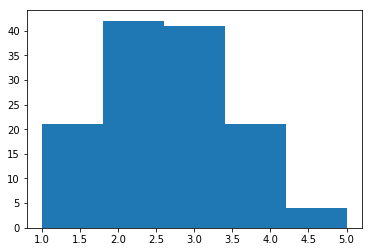

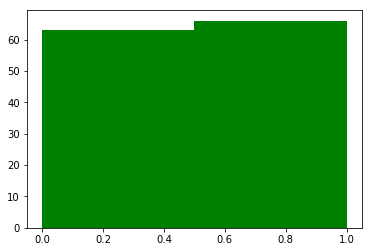

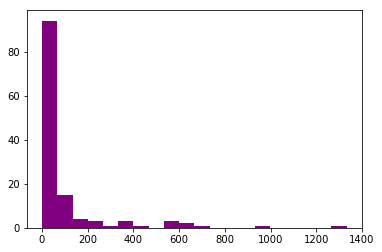

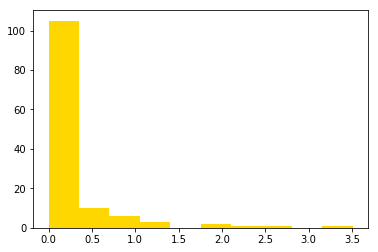

In [11]:
#full_data.hist(column='variable', bins = 5)
plt.hist(full_data.variable, bins = 5)
plt.show()

plt.hist(full_data.binary_label, bins = 2, color='green')
plt.show()

plt.hist(full_data.n_tweets, bins = 20, color = 'purple')
plt.show()

plt.hist(full_data.ratio, color = 'gold')
plt.show()

### Filter Users

In [12]:
#drop the user in turkish
full_data = full_data.drop(full_data[full_data.index == 2697].index)
#drop not common tweeters
full_data = full_data.drop(full_data[full_data.n_tweets == 1].index)
full_data = full_data.drop(full_data[full_data.n_tweets > 800].index)

In [13]:
fold1, fold2, fold3, fold4, fold5 = create_folds(full_data,5)

In [14]:
label, pred = 'binary_label', 'predictions'

t1, b1 = run_model(full_data, fold1, label, pred)
t2, b2 = run_model(full_data, fold2, label, pred)
t3, b3 = run_model(full_data, fold3, label, pred)
t4, b4 = run_model(full_data, fold4, label, pred)
t5, b5 = run_model(full_data, fold5, label, pred)

binary = pd.DataFrame([b1, b2, b3, b4, b5])
binary.columns = ['ROC AUC Score','Accuracy', 'Recall', 'Precision', 'F-1 Score']
binary.index = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
binary.loc['Mean'] = binary.mean()
binary

,ROC AUC Score,Accuracy,Recall,Precision,F-1 Score
Fold 1,0.564394,0.565217,0.583333,0.583333,0.583333
Fold 2,0.577778,0.583333,0.692308,0.600000,0.642857
Fold 3,0.693182,0.695652,0.692308,0.750000,0.720000
Fold 4,0.791667,0.791667,0.733333,0.916667,0.814815
Fold 5,0.567460,0.521739,0.437500,0.777778,0.560000
Mean,0.638896,0.631522,0.627756,0.725556,0.664201
